In [52]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


In [3]:
# Postgres info to connect

connection_args = {
    'host': 'localhost',
    'dbname': 'nfl_db',
    'port': 5432
}

connection = pg.connect(**connection_args) # Unpacks dictionary keys and values

In [4]:
# initial preview of table

query = "SELECT * FROM nfl_plays LIMIT 10;"
pd_sql.read_sql(query, connection)

,index,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
1,1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
2,2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
3,3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
4,4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
5,5,162,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
6,6,183,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
7,7,207,2009091000,PIT,TEN,TEN,away,PIT,TEN,94.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
8,8,228,2009091000,PIT,TEN,TEN,away,PIT,TEN,96.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
9,9,253,2009091000,PIT,TEN,PIT,home,TEN,TEN,43.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0


In [20]:
# find information on all columns

query = "SELECT * FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = N'nfl_plays';"
pd_sql.read_sql(query, connection)

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,nfl_db,public,nfl_plays,index,1,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,nfl_db,public,nfl_plays,play_id,2,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,nfl_db,public,nfl_plays,game_id,3,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,nfl_db,public,nfl_plays,home_team,4,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,nfl_db,public,nfl_plays,away_team,5,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,nfl_db,public,nfl_plays,posteam,6,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,nfl_db,public,nfl_plays,posteam_type,7,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,nfl_db,public,nfl_plays,defteam,8,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,nfl_db,public,nfl_plays,side_of_field,9,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,nfl_db,public,nfl_plays,yardline_100,10,None,YES,double precision,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [45]:
# check play_types of plays with negative yards gained

query = "SELECT play_type, COUNT(*) FROM nfl_plays WHERE yards_gained < 0 GROUP BY play_type;"

pd_sql.read_sql(query, connection)

,play_type,count
0,pass,13988
1,punt,1
2,qb_kneel,3588
3,run,13157


In [41]:
# check yard loss play details **NEED TO RENAME COLUMN 'desc' TO 'description'**

query = "SELECT game_date, qtr, time, home_team, description, play_type, yards_gained, yardline_100\
        FROM nfl_plays WHERE yards_gained < 0 AND game_date > '2018-11-01' ORDER BY yards_gained ASC LIMIT 20;"

pd.set_option('display.max_colwidth', -1)
pd_sql.read_sql(query, connection)

,game_date,qtr,time,home_team,description,play_type,yards_gained,yrdln,yardline_100
0,2018-12-02,4,08:26:00,DET,"(8:26) M.Stafford sacked at DET 29 for -13 yards (A.Donald). FUMBLES (A.Donald) [A.Donald], RECOVERED by LA-S.Ebukam at DET 24. S.Ebukam to DET 24 for no gain (L.Toilolo).",pass,-18.0,DET 42,58.0
1,2018-12-16,4,00:24:00,CHI,"(:24) (Shotgun) A.Rodgers sacked at CHI 27 for -18 yards (L.Floyd). Penalty on GB, Illegal Shift, declined.",pass,-18.0,CHI 9,9.0
2,2018-12-02,4,09:20:00,SEA,(9:20) G.Fant reported in as eligible. R.Wilson sacked at SF 17 for -16 yards (R.Blair).,pass,-16.0,SF 1,1.0
3,2018-12-09,1,01:34:00,GB,"(1:34) (Shotgun) M.Ryan sacked at GB 26 for -7 yards. FUMBLES, recovered by ATL-T.Coleman at GB 35. T.Coleman to GB 35 for no gain (J.Alexander).",pass,-16.0,GB 19,19.0
4,2018-11-19,3,13:38:00,LA,"(13:38) (Shotgun) P.Mahomes sacked at LA 36 for -11 yards (A.Donald). FUMBLES (A.Donald) [A.Donald], touched at LA 41, RECOVERED by LA-J.Franklin at KC 46. J.Franklin to KC 46 for no gain (A.Reiter).",pass,-16.0,LA 25,25.0
5,2018-11-11,4,06:08:00,LA,"(6:08) (Shotgun) R.Wilson sacked at SEA 23 for -9 yards (D.Fowler). FUMBLES (D.Fowler), touched at SEA 17, RECOVERED by LA-D.Fowler at SEA 9. D.Fowler to SEA 9 for no gain (J.Simmons).",pass,-15.0,SEA 32,68.0
6,2018-11-11,2,11:20:00,OAK,"(11:20) (Shotgun) D.Carr sacked at LAC 30 for -9 yards (M.Ingram). FUMBLES (M.Ingram) [M.Ingram], RECOVERED by LAC-C.Liuget at LAC 36. C.Liuget to OAK 40 for 24 yards (J.Richard). 4-yards loose ball yardage.",pass,-15.0,LAC 21,21.0
7,2018-11-11,4,06:08:00,LA,"(6:08) (Shotgun) R.Wilson sacked at SEA 23 for -9 yards (D.Fowler). FUMBLES (D.Fowler), touched at SEA 17, RECOVERED by LA-D.Fowler at SEA 9. D.Fowler to SEA 9 for no gain (J.Simmons).",pass,-15.0,SEA 32,68.0
8,2018-11-11,2,11:20:00,OAK,"(11:20) (Shotgun) D.Carr sacked at LAC 30 for -9 yards (M.Ingram). FUMBLES (M.Ingram) [M.Ingram], RECOVERED by LAC-C.Liuget at LAC 36. C.Liuget to OAK 40 for 24 yards (J.Richard). 4-yards loose ball yardage.",pass,-15.0,LAC 21,21.0
9,2018-12-09,2,11:33:00,WAS,(11:33) (Shotgun) E.Manning sacked at WAS 17 for -14 yards (R.Kerrigan).,pass,-14.0,WAS 3,3.0


In [6]:
# check play_types of plays with zero yards gained

query = "SELECT play_type, COUNT(*) FROM nfl_plays WHERE yards_gained = 0 GROUP BY play_type;"

pd_sql.read_sql(query, connection)

,play_type,count
0,extra_point,10934
1,field_goal,9777
2,kickoff,25552
3,no_play,42417
4,pass,67832
5,punt,23913
6,qb_kneel,235
7,qb_spike,690
8,run,12391
9,None,12874


In [7]:
# check play_types of plays with positive yards gained

query = "SELECT play_type, COUNT(*) FROM nfl_plays WHERE yards_gained > 0 GROUP BY play_type;"

pd_sql.read_sql(query, connection)

,play_type,count
0,no_play,14
1,pass,104753
2,qb_kneel,4
3,run,107038


In [58]:
# create dataframe from selected columns

query = "SELECT play_id, game_date, yards_gained, play_type, home_team, away_team, posteam_type, \
        side_of_field, ydsnet, yardline_100, quarter_seconds_remaining, half_seconds_remaining, \
        game_seconds_remaining, qtr, down, goal_to_go, ydstogo, shotgun, no_huddle, qb_dropback, \
        qb_kneel, qb_spike, qb_scramble \
        FROM nfl_plays \
        WHERE play_type IN ('pass','run');"

df = pd_sql.read_sql(query, connection)

In [59]:
df.head()

,play_id,game_date,yards_gained,play_type,home_team,away_team,posteam_type,side_of_field,ydsnet,yardline_100,...,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble
0,2404,2018-11-12,1.0,run,SF,NYG,home,NYG,60,13.0,...,3,1.0,0.0,10,0,0,0.0,0,0,0
1,2428,2018-11-12,1.0,pass,SF,NYG,home,NYG,60,12.0,...,3,2.0,0.0,9,1,0,1.0,0,0,0
2,2452,2018-11-12,11.0,pass,SF,NYG,home,NYG,60,11.0,...,3,3.0,0.0,8,1,0,1.0,0,0,0
3,2528,2018-11-12,30.0,pass,SF,NYG,away,NYG,53,53.0,...,3,1.0,0.0,10,0,0,1.0,0,0,0
4,2552,2018-11-12,3.0,run,SF,NYG,away,SF,53,23.0,...,3,1.0,0.0,10,0,0,0.0,0,0,0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319369 entries, 0 to 319368
Data columns (total 23 columns):
play_id                      319369 non-null int64
game_date                    319369 non-null object
yards_gained                 319159 non-null float64
play_type                    319369 non-null object
home_team                    319369 non-null object
away_team                    319369 non-null object
posteam_type                 319369 non-null object
side_of_field                319369 non-null object
ydsnet                       319369 non-null int64
yardline_100                 319369 non-null float64
quarter_seconds_remaining    319369 non-null float64
half_seconds_remaining       319352 non-null float64
game_seconds_remaining       319355 non-null float64
qtr                          319369 non-null int64
down                         318691 non-null float64
goal_to_go                   319369 non-null float64
ydstogo                      319369 non-null int64
sh

In [61]:
# count how many rows have NaNs

df1 = df[df.isnull().any(axis=1)]
df1

,play_id,game_date,yards_gained,play_type,home_team,away_team,posteam_type,side_of_field,ydsnet,yardline_100,...,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble
261,3117,2018-11-18,2.0,run,BAL,CIN,home,CIN,80,2.0,...,3,NaN,0.0,0,0,0,0.0,0,0,0
620,3078,2018-11-18,0.0,pass,JAX,PIT,away,JAX,79,2.0,...,3,NaN,0.0,0,0,0,1.0,0,0,0
1020,3944,2018-11-18,0.0,pass,DET,CAR,away,DET,75,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
1119,3323,2018-11-18,0.0,run,LAC,DEN,away,LAC,73,2.0,...,4,NaN,0.0,0,0,0,0.0,0,0,0
1422,1355,2018-11-18,2.0,pass,CHI,MIN,home,MIN,82,2.0,...,2,NaN,0.0,0,0,0,1.0,0,0,0
1492,3923,2018-11-18,2.0,pass,CHI,MIN,away,CHI,74,1.0,...,4,NaN,1.0,0,0,0,1.0,0,0,0
1511,4574,2018-11-18,0.0,pass,CHI,MIN,away,CHI,75,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
1709,1946,2018-11-22,0.0,pass,DET,CHI,away,DET,65,2.0,...,2,NaN,0.0,0,0,0,1.0,0,0,0
1740,2948,2018-11-22,0.0,pass,DET,CHI,home,CHI,80,2.0,...,3,NaN,0.0,0,0,0,1.0,0,0,0
2762,288,2018-11-25,0.0,pass,PHI,NYG,away,PHI,75,1.0,...,1,NaN,1.0,0,0,0,1.0,0,0,0


In [62]:
# 911 out of 319,369 observations have null values, or less than 0.3%
# removing any NaN observations

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318458 entries, 0 to 319368
Data columns (total 23 columns):
play_id                      318458 non-null int64
game_date                    318458 non-null object
yards_gained                 318458 non-null float64
play_type                    318458 non-null object
home_team                    318458 non-null object
away_team                    318458 non-null object
posteam_type                 318458 non-null object
side_of_field                318458 non-null object
ydsnet                       318458 non-null int64
yardline_100                 318458 non-null float64
quarter_seconds_remaining    318458 non-null float64
half_seconds_remaining       318458 non-null float64
game_seconds_remaining       318458 non-null float64
qtr                          318458 non-null int64
down                         318458 non-null float64
goal_to_go                   318458 non-null float64
ydstogo                      318458 non-null int64
sh

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 3:], df.iloc[:, 2], 
                                                    test_size = 0.2, random_state=33)

In [64]:
train_df = X_train.copy()
train_df['yards_gained'] = y_train

train_df['yards_g_l'] = train_df['yards_gained'].apply(lambda x: 'gain' if x > 0 else 'loss')
train_df.head()

,play_type,home_team,away_team,posteam_type,side_of_field,ydsnet,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,...,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,yards_gained,yards_g_l
312696,pass,HOU,MIA,home,MIA,16,13.0,858.0,858.0,2658.0,...,0.0,7,0,0,1.0,0,0,0,13.0,gain
201217,run,NE,BUF,home,NE,27,65.0,586.0,586.0,586.0,...,0.0,6,1,0,1.0,0,0,1,9.0,gain
187114,pass,NYG,IND,away,IND,0,84.0,895.0,1795.0,1795.0,...,0.0,10,0,0,1.0,0,0,0,0.0,loss
37158,pass,WAS,NYG,home,WAS,28,52.0,670.0,670.0,670.0,...,0.0,10,0,0,1.0,0,0,0,5.0,gain
265064,pass,DAL,DET,away,DET,27,52.0,136.0,1036.0,2836.0,...,0.0,4,1,1,1.0,0,0,0,21.0,gain


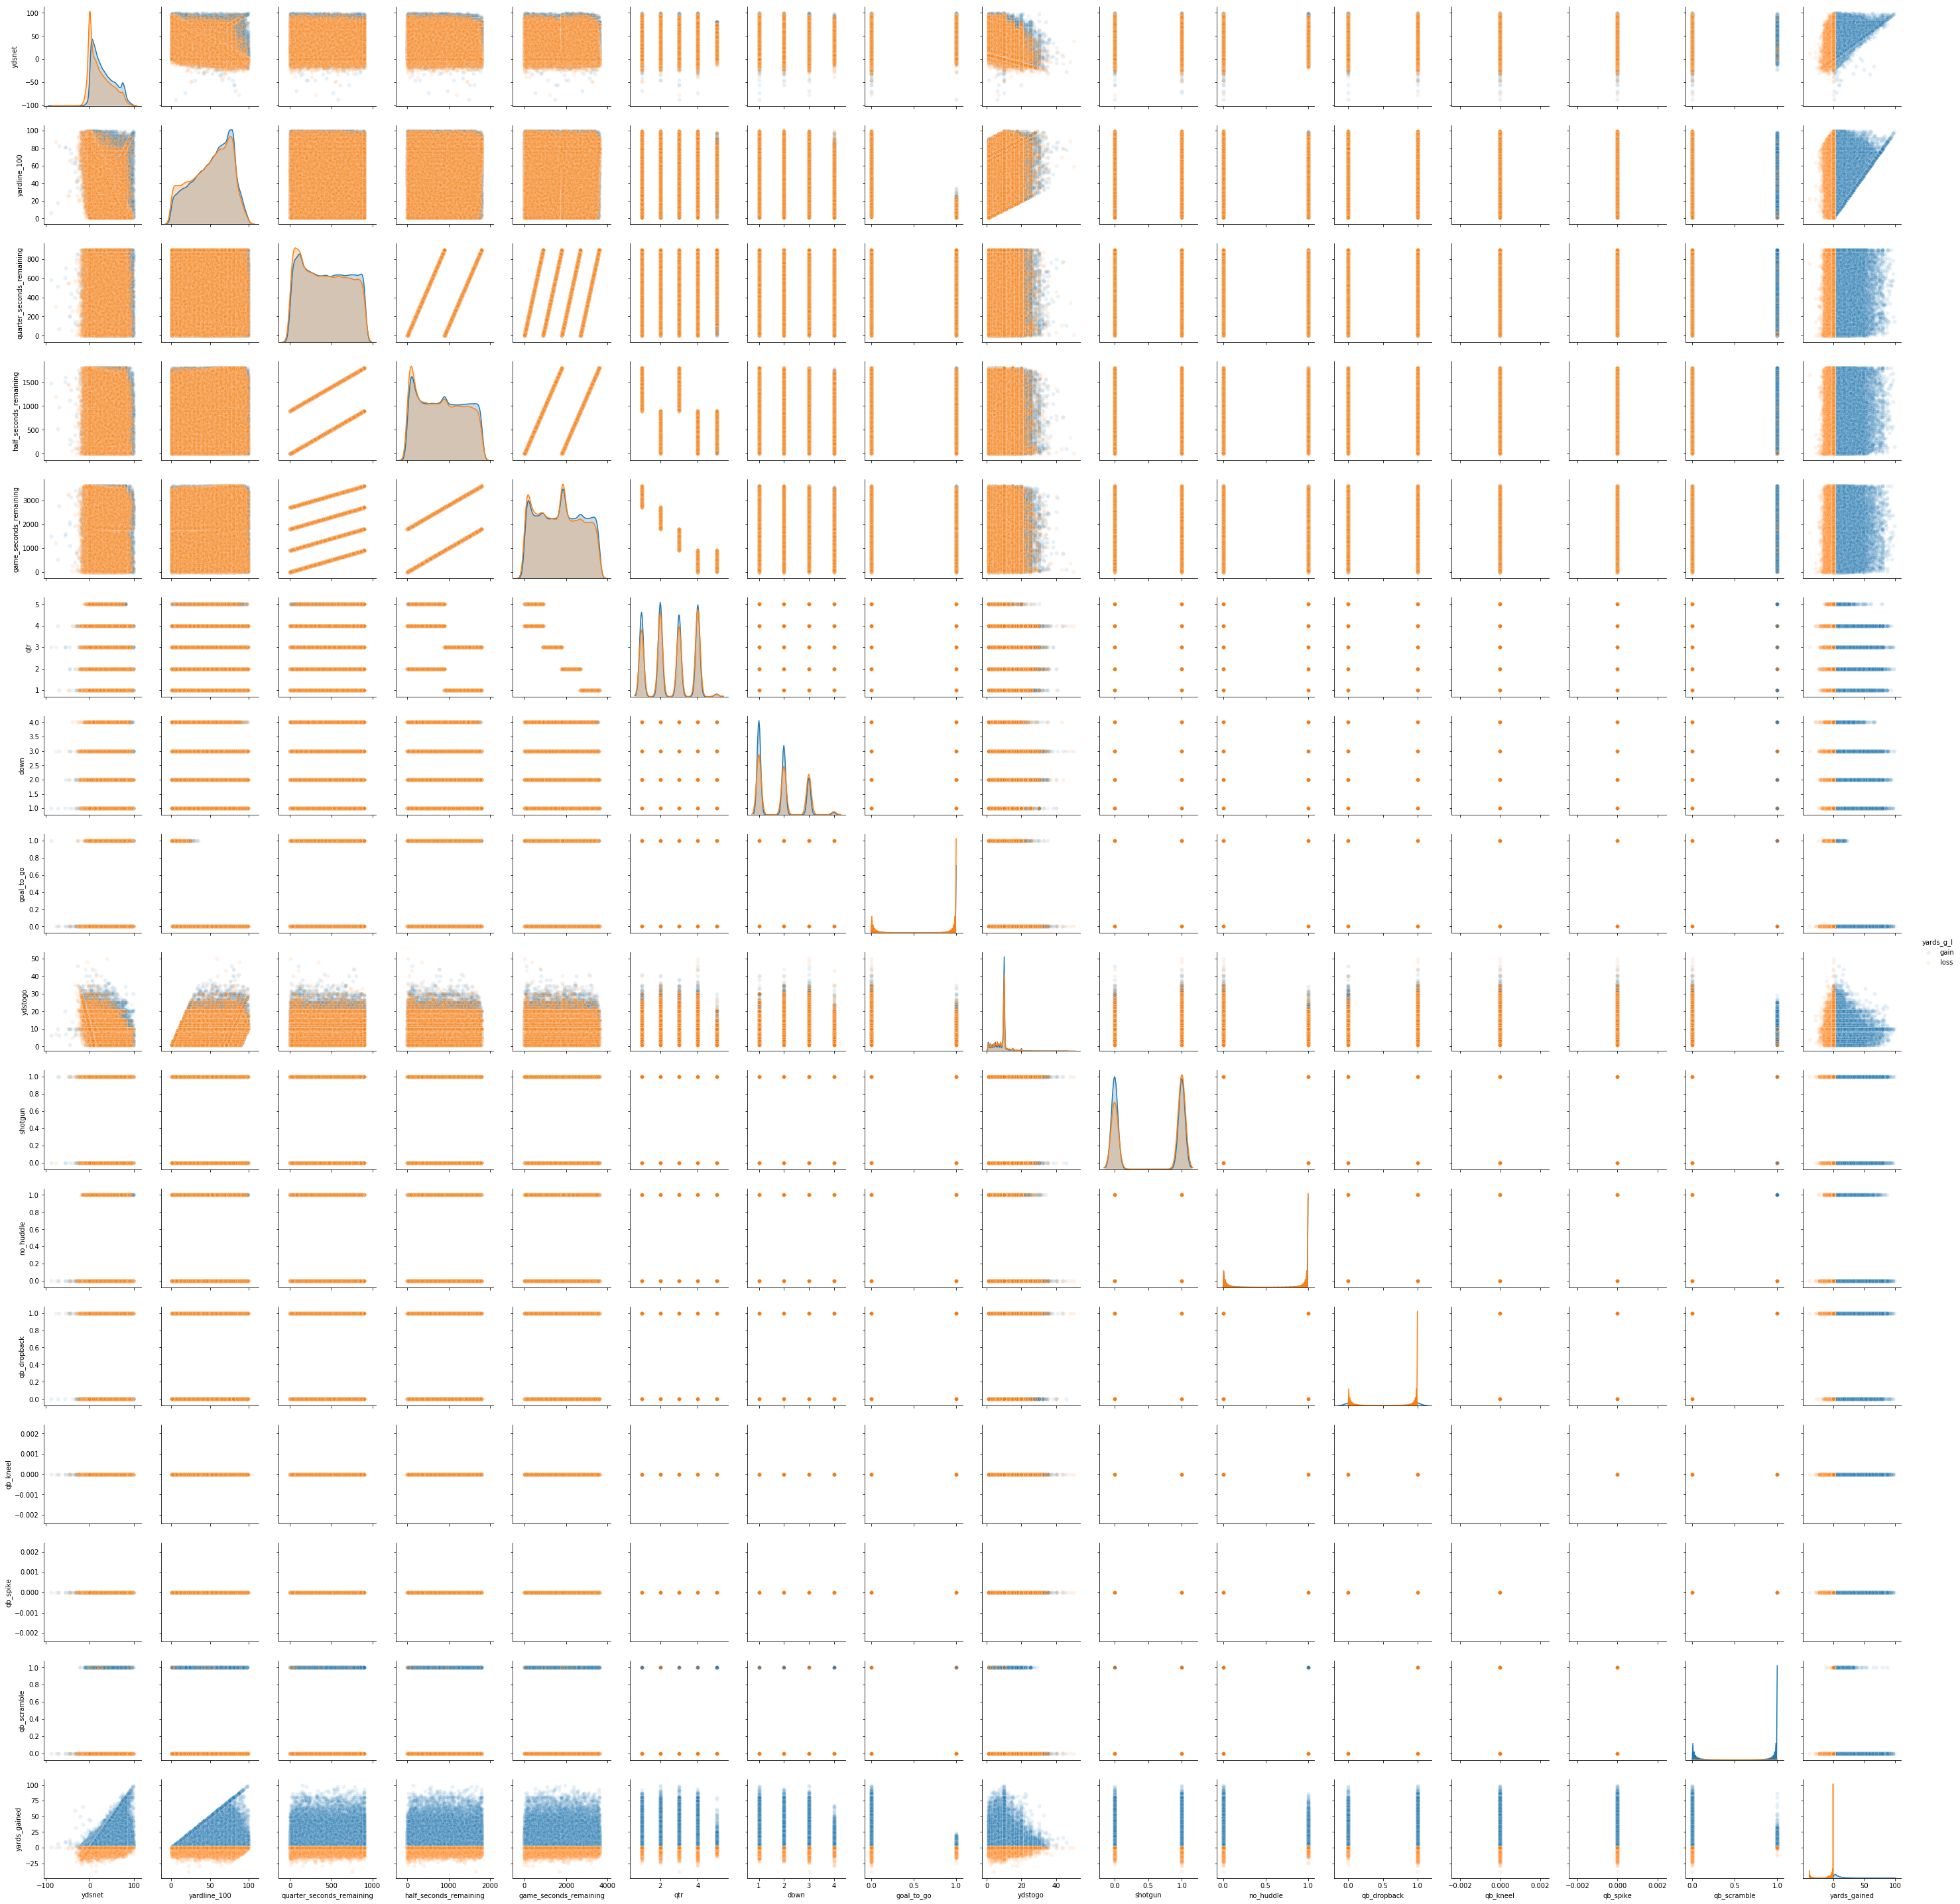

In [67]:
sns.pairplot(train_df.iloc[:, 5:], hue='yards_g_l', plot_kws={'alpha': 0.1});